# Lab 5: Backpropagation from Scratch

This lab extends Lab 4's neural network to include training with backpropagation and gradient descent. We'll train it on the XOR dataset.

In [ ]:
# Random number generator
import math
import csv

class SimpleRandom:
    def __init__(self, seed, a=100000000, c=12345, mod=2**32):
        self.state = seed
        self.a = a
        self.c = c
        self.mod = mod

    def rand(self):
        self.state = (self.a * self.state + self.c) % self.mod
        return self.state / self.mod

rng = SimpleRandom(seed=42)

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def sigmoid_derivative(output):
    return output * (1 - output)

def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-12
    y_pred = max(min(y_pred, 1 - epsilon), epsilon)
    return -(y_true * math.log(y_pred) + (1 - y_true) * math.log(1 - y_pred))

In [2]:
# Node, Layer, NeuralNetwork with backpropagation
class Node:
    def __init__(self, input_size, weights=None, bias=None):
        if weights:
            self.weights = weights
        else:
            self.weights = [rng.rand() for _ in range(input_size)]
        self.bias = bias if bias is not None else rng.rand()
        self.output = 0
        self.input = []
        self.delta = 0

    def forward(self, inputs):
        self.input = inputs
        total = sum(w * i for w, i in zip(self.weights, inputs)) + self.bias
        self.output = sigmoid(total)
        return self.output

    def compute_output_delta(self, target):
        error = self.output - target
        self.delta = error * sigmoid_derivative(self.output)

    def compute_hidden_delta(self, next_weights, next_deltas):
        error = sum(w * d for w, d in zip(next_weights, next_deltas))
        self.delta = error * sigmoid_derivative(self.output)

    def update_weights(self, learning_rate):
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * self.delta * self.input[i]
        self.bias -= learning_rate * self.delta

In [3]:
class Layer:
    def __init__(self, input_size, output_size, weights=None, biases=None):
        self.nodes = []
        for i in range(output_size):
            w = weights[i] if weights else None
            b = biases[i] if biases else None
            self.nodes.append(Node(input_size, w, b))

    def forward(self, inputs):
        return [node.forward(inputs) for node in self.nodes]

    def backward(self, target_outputs=None, next_layer=None):
        if target_outputs is not None:
            for node, target in zip(self.nodes, target_outputs):
                node.compute_output_delta(target)
        else:
            for i, node in enumerate(self.nodes):
                next_weights = [n.weights[i] for n in next_layer.nodes]
                next_deltas = [n.delta for n in next_layer.nodes]
                node.compute_hidden_delta(next_weights, next_deltas)

    def update_weights(self, learning_rate):
        for node in self.nodes:
            node.update_weights(learning_rate)

In [4]:
class NeuralNetwork:
    def __init__(self, layer_sizes):
        self.layers = [Layer(layer_sizes[i], layer_sizes[i+1]) for i in range(len(layer_sizes)-1)]

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def train(self, data, labels, epochs=1000, learning_rate=0.5):
        for epoch in range(epochs):
            total_loss = 0
            for x, y in zip(data, labels):
                output = self.forward(x)
                total_loss += binary_cross_entropy(y[0], output[0])

                self.layers[-1].backward([y[0]])
                for i in reversed(range(len(self.layers)-1)):
                    self.layers[i].backward(next_layer=self.layers[i+1])

                for layer in self.layers:
                    layer.update_weights(learning_rate)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}: Loss = {total_loss / len(data):.4f}")

    def predict(self, x):
        return [1 if o >= 0.5 else 0 for o in self.forward(x)]

In [5]:
# Load XOR dataset manually
data = [
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1],
]
labels = [
    [0],
    [1],
    [1],
    [0],
]

# Create and train network
nn = NeuralNetwork([2, 2, 1])
nn.train(data, labels, epochs=1000, learning_rate=0.5)

print("\nPredictions on XOR:")
for x in data:
    print(f"Input: {x}, Predicted: {nn.predict(x)}")

Epoch 0: Loss = 0.9613
Epoch 100: Loss = 0.7240
Epoch 200: Loss = 0.7199
Epoch 300: Loss = 0.7087
Epoch 400: Loss = 0.6812
Epoch 500: Loss = 0.6329
Epoch 600: Loss = 0.5822
Epoch 700: Loss = 0.5330
Epoch 800: Loss = 0.4453
Epoch 900: Loss = 0.2903

Predictions on XOR:
Input: [0, 0], Predicted: [0]
Input: [0, 1], Predicted: [1]
Input: [1, 0], Predicted: [1]
Input: [1, 1], Predicted: [0]


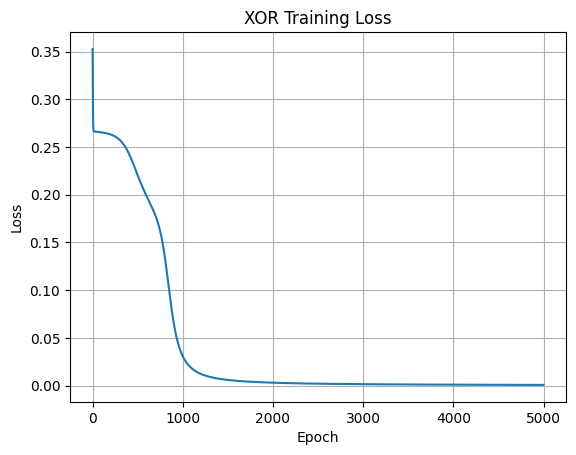

XOR Results:
[0, 0] => 0.0289
[0, 1] => 0.9746
[1, 0] => 0.9746
[1, 1] => 0.0266


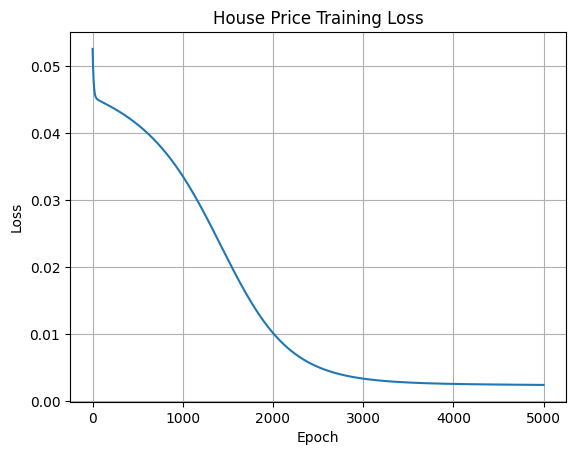


House Price Predictions:
Size: 10 => Predicted Price: 59.50
Size: 20 => Predicted Price: 73.11
Size: 40 => Predicted Price: 103.36
Size: 60 => Predicted Price: 126.22
Size: 80 => Predicted Price: 137.71


In [ ]:
import math
import matplotlib.pyplot as plt

class SimpleRandom:
    def __init__(self, seed=42, a=1103515245, c=12345, mod=2**32):
        self.state = seed
        self.a = a
        self.c = c
        self.mod = mod

    def rand(self):
        self.state = (self.a * self.state + self.c) % self.mod
        return self.state / self.mod

rng = SimpleRandom()

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def sigmoid_derivative(output):
    return output * (1 - output)

class Node:
    def __init__(self, input_size):
        self.weights = [rng.rand() for _ in range(input_size)]
        self.bias = rng.rand()
    
    def forward(self, inputs):
        self.inputs = inputs
        self.z = sum(w * i for w, i in zip(self.weights, inputs)) + self.bias
        self.output = sigmoid(self.z)
        return self.output

    def backward(self, delta):
        self.dweights = [delta * i for i in self.inputs]
        self.dbias = delta

    def update(self, lr):
        for i in range(len(self.weights)):
            self.weights[i] -= lr * self.dweights[i]
        self.bias -= lr * self.dbias

# Layer
class Layer:
    def __init__(self, input_size, output_size):
        self.nodes = [Node(input_size) for _ in range(output_size)]

    def forward(self, inputs):
        self.inputs = inputs
        self.outputs = [node.forward(inputs) for node in self.nodes]
        return self.outputs

    def backward(self, deltas, next_weights=None):
        new_deltas = [0] * len(self.inputs)
        for j, node in enumerate(self.nodes):
            delta = deltas[j] * sigmoid_derivative(node.output)
            node.backward(delta)
            for i, w in enumerate(node.weights):
                new_deltas[i] += delta * w
        return new_deltas

    def update(self, lr):
        for node in self.nodes:
            node.update(lr)

    def get_weights(self):
        return [node.weights for node in self.nodes]

# Neural network
class NeuralNetwork:
    def __init__(self, layer_sizes):
        self.layers = []
        for i in range(len(layer_sizes) - 1):
            self.layers.append(Layer(layer_sizes[i], layer_sizes[i + 1]))

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def train(self, X, Y, lr=0.1, epochs=5000):
        loss_history = []
        for epoch in range(epochs):
            total_loss = 0
            for x, y in zip(X, Y):
                output = self.forward(x)
                loss = sum((o - yt) ** 2 for o, yt in zip(output, y)) / len(y)
                total_loss += loss

                # Backward
                deltas = [o - yt for o, yt in zip(output, y)]
                for i in reversed(range(len(self.layers))):
                    deltas = self.layers[i].backward(deltas)

                # Update
                for layer in self.layers:
                    layer.update(lr)

            loss_history.append(total_loss / len(X))
        return loss_history

# XOR dataset
X_xor = [[0, 0], [0, 1], [1, 0], [1, 1]]
Y_xor = [[0], [1], [1], [0]]

nn_xor = NeuralNetwork([2, 2, 1])
loss_xor = nn_xor.train(X_xor, Y_xor, lr=0.5, epochs=5000)

# Plot XOR loss
plt.plot(loss_xor)
plt.title("XOR Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# XOR Results
print("XOR Results:")
for x in X_xor:
    y_pred = nn_xor.forward(x)[0]
    print(f"{x} => {y_pred:.4f}")

# House dataset (lr.csv)
X_price = [[10], [20], [40], [60], [80]]
Y_price = [[55], [80], [100], [120], [150]]

# Normalize
X_price_norm = [[x[0]/100] for x in X_price]
Y_price_norm = [[y[0]/150] for y in Y_price]

nn_price = NeuralNetwork([1, 3, 1])
loss_price = nn_price.train(X_price_norm, Y_price_norm, lr=0.1, epochs=5000)

# Plot House Price Loss
plt.plot(loss_price)
plt.title("House Price Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Prediction
print("\nHouse Price Predictions:")
for x in X_price:
    x_norm = [x[0]/100]
    y_pred = nn_price.forward(x_norm)[0] * 150
    print(f"Size: {x[0]} => Predicted Price: {y_pred:.2f}")
